In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
from sklearn import linear_model

# cluster functions
empty = [0]
point = [1,2]
pair_1 = [3,4,5]; pair_2 = [6,7,8] 
pair_3 = [9,10,11,12]; pair_4 = [13,14,15]
triplet_1 = [16,17,18,19] 
triplet_2 = [20,21,22,23]
triplet_3 = [24,25,26,27,28,29]

def find_corr(df_corr_full, df_abs):
    df_corr = pd.DataFrame(columns=df_corr_full.columns)
    for i in df_abs.index:
        df_ = df_corr_full[df_corr_full['configname'] == df_abs.loc[i, 'configname']]
        df_corr = df_corr.append(df_, ignore_index=True)
    return df_corr

def regularize(df, grid_fine, smooth_width=0):
    df_fine = pd.DataFrame(index=df.index, columns=['configname', 'energy', 'abs_coef', 'ahv', 'gap'])
    for i in df.index:
        abs_coef = df.loc[i, "abs_coef"]
        ahv = df.loc[i, "ahv"]
        grid_coarse = df.loc[i, "energy"]
        if smooth_width > 0:
            box = np.ones(smooth_width)/smooth_width
            abs_coef = np.convolve(dos, box, mode='same')
        f = interpolate.interp1d(grid_coarse,abs_coef)
        df_fine.loc[i,"abs_coef"] = f(grid_fine)
        f = interpolate.interp1d(grid_coarse,ahv)
        df_fine.loc[i,"ahv"] = f(grid_fine)
        df_fine.loc[i,"energy"] = grid_fine
        df_fine.loc[i,"gap"] = df.loc[i, "gap"]
        df_fine.loc[i,"configname"] = df.loc[i, "configname"]
    return df_fine

def calc_abs(df):
    df['abs_coef'] = np.nan
    df['abs_coef'] = df['abs_coef'].astype(object)
    df['ahv'] = np.nan
    df['ahv'] = df['ahv'].astype(object)
    for i in df.index:
        eps_r = df.loc[i].eps_r.mean(axis=1)
        eps_i = df.loc[i].eps_i.mean(axis=1)
        #
        eps_r = df.loc[i].eps_r[:,0]
        eps_i = df.loc[i].eps_i[:,0]
        #
        omega = df.loc[i].energy
        kappa = np.sqrt((np.sqrt(eps_r**2+eps_i**2) - eps_r)/2)
        abs_coef = 4*np.pi*omega*kappa*8065.5
        df.at[i, 'abs_coef'] = abs_coef
        df.at[i, 'ahv'] = (abs_coef * omega)**2
        
def select_cluster(df_corr, clusters):
    if len(clusters) > 1:
        clus = []
        for i in clusters:
            clus = clus + i
    else:
        clus = clusters
    clus = np.array(clus)
    return df_corr.iloc[:,clus]

def weight(df, w_exp):
    w = np.exp(df.gap.values.astype(float)/w_exp)
    #print(np.hstack((df.gap.values[:,np.newaxis], w[:,np.newaxis])))
    return w

def calc_eci(corr,x, w):
    xx = np.concatenate(x.values)
    nabs = len(xx)/len(corr)
    xx = xx.reshape(len(corr), int(nabs))
    eci = linear_model.LinearRegression(fit_intercept=False)
    eci.fit(corr.values, xx, w)
    return eci

def pred(corr,eci):
    return np.dot(corr, eci.coef_.T)

def main(mat, clusters, thr_gap=0.2, w_exp=0.5, ref=3, verbose=False):
    global grid, df_abs
    # read corr matrix and electronic densities
    df_corr_full = pd.read_csv('corr_{0}_abs.csv'.format(mat), delim_whitespace=True)
    df_abs = pd.read_hdf('ipa_{0}.h5'.format(mat))
    # load relevant corr matrix
    df_corr = find_corr(df_corr_full, df_abs)
    # calculate the absorption coeff from dieletric functions
    calc_abs(df_abs)
    # regularize the energy mesh
    energy_regular = np.linspace(0,1.2,61)
    df_abs = regularize(df_abs, energy_regular)
    # semiconductors only; drop metallic structures
    semi = df_abs[(df_abs.gap >= thr_gap)].index
    df_corr = df_corr.loc[semi]
    df_abs = df_abs.loc[semi]
    if verbose:
        display(df_abs)
        display(df_corr);
    grid = df_abs.iloc[0]['energy']
    # define training set
    train = df_corr.sample(frac=0.9)
    corr_train = train.loc[:,"corr(0)":"corr(29)"]
    abs_train = df_abs.loc[train.index,'abs_coef']
    ahv_train = df_abs.loc[train.index,'ahv']
    # test set
    test = df_corr.drop(train.index)
    corr_test = test.loc[:,"corr(0)":"corr(29)"]
    abs_test = df_abs.drop(train.index).loc[:,'abs_coef']
    ahv_test = df_abs.drop(train.index).loc[:,'ahv']
    # include the pair interactions up to the 5th NN, and the triplets up to the 2NN
    corr_train = select_cluster(corr_train, clusters)
    corr_test = select_cluster(corr_test, clusters)
    #
    w = weight(df_abs.loc[train.index], w_exp)
    eci = calc_eci(corr_train, abs_train, w)
    abs_train_pred = pred(corr_train, eci)
    abs_test_pred = pred(corr_test, eci)
    # error
    rms_train = np.sqrt(np.mean((abs_train_pred - np.array(abs_train.values.tolist()))**2))
    rms_test  = np.sqrt(np.mean((abs_test_pred - np.array(abs_test.values.tolist()))**2))
    # plot the real abs coef. (gray) and the predicted ones (red)
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2)
    for i in range(len(abs_train)):
        ax0.plot(grid, abs_train.iloc[i], color='gray')
        ax0.plot(grid, abs_train_pred[i], color='r')
    ax0.plot(grid, df_abs.loc[ref,'abs_coef'], color='b')
    ax0.text(0.6, 0.2, 'RMS = {0:8.1f}'.format(rms_train), transform=ax0.transAxes)
    ax0.set_title("Cluster expanded abs coeff: Training set")
    ax0.set_yscale("log")
    ax0.set_ylabel(r"$\alpha$ (cm$^{-1}$)")
    ax1.set_ylabel(r"$\alpha$ (cm$^{-1}$)")

    for i in range(len(abs_test)):
        ax1.plot(grid, abs_test.iloc[i], color='gray')
        ax1.plot(grid, abs_test_pred[i], color='r')
    ax1.set_title("Cluster expanded abs coeff: Test set")
    ax1.text(0.6, 0.2, 'RMS = {0:8.1f}'.format(rms_test), transform=ax1.transAxes)
    ax1.set_yscale("log")
    # plot eci vs energy
    for i in range(len(eci.coef_[0])):
        ax2.plot(grid, eci.coef_[:,i], label=i)
    ax2.set_title("Effective cluster absorption coeff")
    ax2.legend()
    ax2.set_yscale("log")
    ax2.set_ylabel(r"$\alpha$ (cm$^{-1}$)")
    # tauc plot
    ax3.set_ylabel(r"$(\alpha h \nu)^2$ (eV$^{2}$cm$^{-2}$)")
    for i in df_abs.index:
        ax3.plot(grid, df_abs.loc[i, 'ahv'])
        ax3.set_xlim([0.2,1.2])
        ax3.set_ylim([0,2e9])
    for ax in [ax0, ax1]:
        ax.set_xlim([0.2,1.2])
        ax.set_ylim([1e2, 1e5])
    return eci

def ec_abs(mat,clusters,eci,ref_number):
    # plot DOS vs Temperature using the correlation matrix from MC simulations
    df_mc = pd.read_csv('mc_{0}.csv'.format(mat), delim_whitespace=True)
    df_mc = df_mc[df_mc['T'] <= 1000].reset_index()
    corr_str = []
    for i in range(30):
        corr_str.append("<corr({0:})>".format(i))
    df_corr_mc = df_mc.loc[:,corr_str]
    corr_mc = select_cluster(df_corr_mc, clusters)
    #
    abs_mc_pred = pred(corr_mc, eci)
    # 
    plt.rcParams['figure.figsize'] = [14, 14]
    fig, ((ax0, ax1),(ax2,ax3)) = plt.subplots(2,2)
    norm = mpl.colors.Normalize(vmin=df_mc["T"].min(), vmax = df_mc["T"].max())
    cmap = mpl.cm.get_cmap('jet')
    c = [cmap(norm(temp)) for temp in df_mc["T"]]
    for i in range(len(abs_mc_pred)):
        ax0.plot(grid, abs_mc_pred[i], color=c[i])
        ax1.plot(grid, abs_mc_pred[i], color=c[i])
    for ax in [ax0, ax1]:
        cax, _ = mpl.colorbar.make_axes(ax)
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
        ax.set_ylabel(r"$\alpha$ (cm$^{-1}$)")
        # plot the kesterite reference abs
        ax.plot(grid, df_abs.loc[ref_number, "abs_coef"], 'k--', label='reference');
    for i in range(len(abs_mc_pred)):
        ax2.plot(grid, (abs_mc_pred[i]*grid)**2, color=c[i])
        ax3.plot(grid, (abs_mc_pred[i]*grid)**2, color=c[i])
    for ax in [ax2, ax3]:
        cax, _ = mpl.colorbar.make_axes(ax)
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
        ax.set_ylabel(r"$(\alpha h \nu)^2$ (eV$^{2}$cm$^{-2}$)")
        # plot the kesterite reference abs
        ax.plot(grid, df_abs.loc[ref_number, "abs_coef"]**2*grid**2, 'k--', label='reference');
    for ax in [ax0, ax1, ax2, ax3]:
        ax.set_xlim([0.2,1.0])
    ax1.set_ylim([1e2, 5e4])
    ax1.set_yscale("log")
    ax3.set_yscale("log")
    ax1.legend();

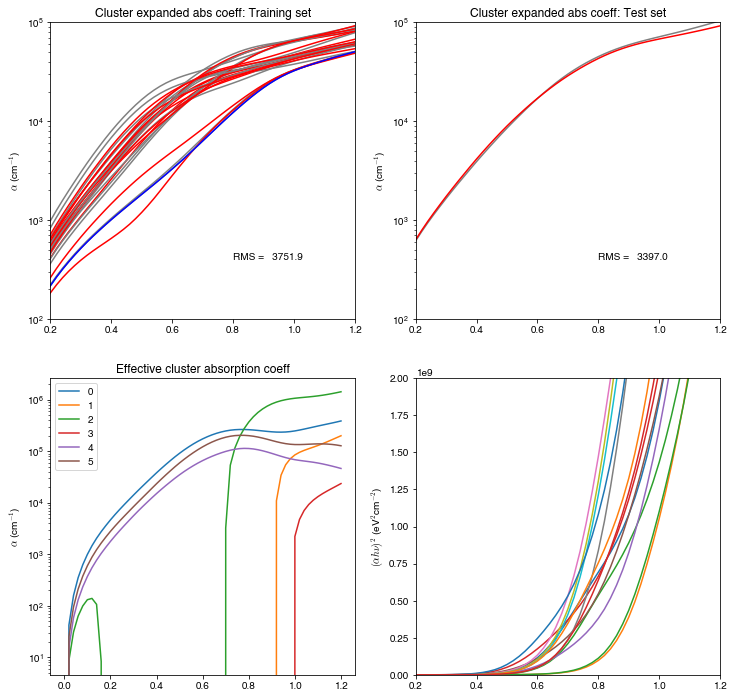

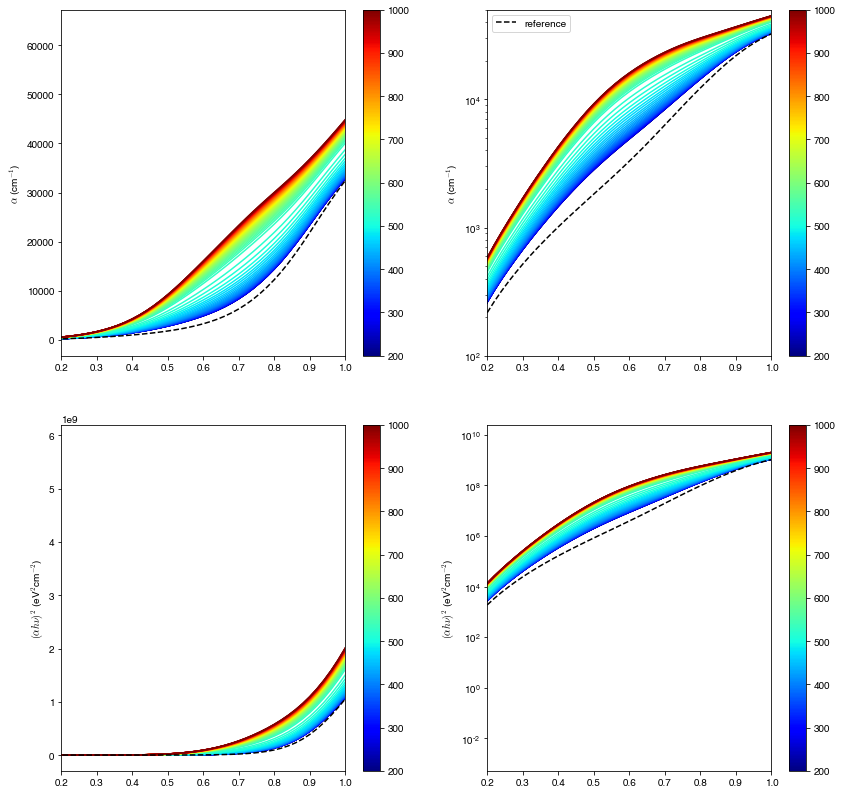

In [2]:
clusters = [pair_1, pair_2]
eci_czts = main("czts", clusters, thr_gap=0.20, w_exp=0.2, ref=3, verbose=False)
ec_abs("czts", clusters, eci_czts, 3)
plt.show()

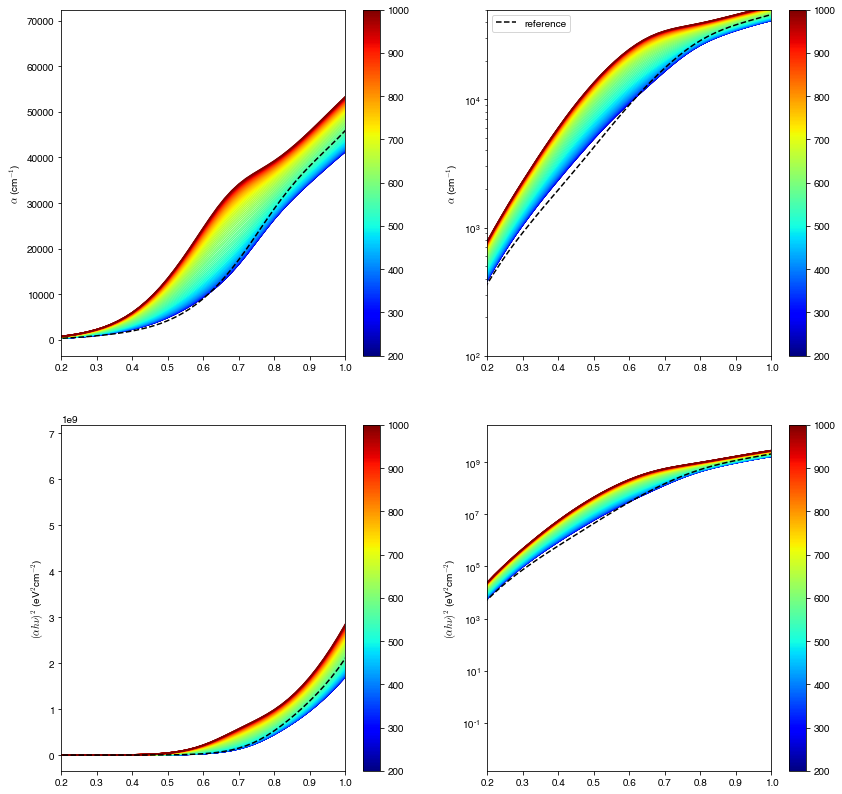

In [3]:
clusters = [pair_1, pair_2]
eci_ccts = main("ccts", clusters, thr_gap=0.2, w_exp=0.2, ref=42, verbose=False)
ec_abs("ccts", clusters, eci_ccts, 42)
plt.show()